# Load ModelNet10

In [1]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
path = Path("./ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes


{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [3]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
        layout=go.Layout(
            updatemenus=[dict(type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
        ),
        frames=frames
    )

    return fig


def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

In [4]:
with open(path/"bathtub/train/bathtub_0001.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)


3514

In [5]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='yellowgreen', opacity=0.50, i=i,j=j,k=k)]).show()

In [6]:


pcshow(x,y,z)



In [7]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [8]:
pointcloud = PointSampler(128)((verts, faces))
pcshow(*pointcloud.T)

In [9]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [10]:


norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)



In [11]:
type(norm_pointcloud)

numpy.ndarray

In [12]:
norm_pointcloud.shape

(128, 3)

In [13]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(128),
                                # Normalize(),
                                # ToTensor()
                              ])

In [14]:
train_transforms = transforms.Compose([
                                PointSampler(128),
                                # Normalize(),
])

In [15]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}
        # return np.concatenate(pointcloud, self.classes[category])

In [16]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [17]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [18]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].shape)
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  (128, 3)
Class:  bathtub


In [19]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [20]:
train_ds[3000]['category']

7

In [21]:
type(train_ds[0])

dict

In [22]:
train_ds[0]

{'pointcloud': array([[ 16.5611    ,   5.26734722,  -2.70119964],
        [ -4.21363918, -47.625     ,  -5.71859852],
        [-24.375     ,  31.27042669,  -2.02310671],
        [-13.92082375, -33.23475387,   6.74854201],
        [  8.16936391,  47.625     ,  11.64128803],
        [-12.30898208, -46.50437664, -18.0191    ],
        [  4.58474206, -22.63351906, -18.0191    ],
        [ 18.90001754, -47.625     ,   8.51198256],
        [  9.38619667,  47.625     ,   6.44075417],
        [ 21.01191821,   7.2537984 , -18.0191    ],
        [-24.375     ,  24.43603589, -16.87865018],
        [ 20.60221615,  10.87626225, -18.0191    ],
        [ -6.20923603,   0.69788614, -12.2691    ],
        [-11.23668584, -34.79227604, -12.2691    ],
        [-18.0014    ,  11.00204429,  -5.88860022],
        [-11.22794285, -35.52717067,   7.95669938],
        [  4.88416066,  -9.77611592, -12.2691    ],
        [-24.375     ,  23.54597507,  -8.03105689],
        [ 16.5611    ,  -6.49672954,  -8.81695437]

In [23]:
import pandas as pd

In [24]:
d = {}

i = 0


for entry in train_ds:

    # add a dictionary entry to the final dictionary
    d[i] = {"pointcloud": entry['pointcloud'], "category": entry['category']}
    
    # increment the counter
    i = i + 1
    # print(i)

train_df = pd.DataFrame.from_dict(d, 'index')

In [25]:
d = {}

i = 0


for entry in valid_ds:

    # add a dictionary entry to the final dictionary
    d[i] = {"pointcloud": entry['pointcloud'], "category": entry['category']}
    
    # increment the counter
    i = i + 1
    # print(i)

valid_df = pd.DataFrame.from_dict(d, 'index')

In [26]:
train_df.tail()

,pointcloud,category
3986,"[[3.48699692960776, -5.147212398084522, -6.624...",9
3987,"[[-0.7927446968836996, -11.718340337125872, -0...",9
3988,"[[-0.8698236841164085, 4.668955527402681, -6.7...",9
3989,"[[50.66001534634654, -348.90887316121626, 150....",9
3990,"[[-21.987866371965843, -37.45176332976561, 0.0...",9


In [27]:
pcshow(*valid_df['pointcloud'][0].T)

In [28]:
# train_df['pointcloud'][0]

In [29]:
x_train = np.stack(np.asarray(train_df['pointcloud']), axis=0)
# print(x_train.shape)
# x_train = x_train.reshape(3991, 256, 3)
x_train.shape

(3991, 128, 3)

In [30]:
# x_train[0]

In [31]:
pcshow(*x_train[0].T)

In [32]:
y_train = np.asarray(train_df['category'])
y_train.shape

(3991,)

In [33]:
x_test = np.stack(np.asarray(valid_df['pointcloud']), axis=0)
# x_test = x_test.reshape(908, 256, 3)
x_test.shape

(908, 128, 3)

In [34]:
y_test = np.asarray(valid_df['category'])
y_test.shape

(908,)

### One-hot encoding of labels

In [35]:
from sklearn.preprocessing import OneHotEncoder

one = OneHotEncoder()
y_test_one = one.fit_transform(y_test.reshape(-1,1))
y_train_one = one.fit_transform(y_train.reshape(-1,1))
y_train_one[-1].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

# Define persistance diagrams

In [36]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_point_cloud


In [37]:
homology_dimensions = [0, 1, 2]


persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(x_train)

In [38]:
persistence_entropy = PersistenceEntropy(normalize=True)
# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)
# Visualise feature matrix
# plot_point_cloud(X)

In [39]:
from gtda.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [40]:
rf = RandomForestClassifier(oob_score=True, random_state=42)

rf.fit(X, y_train)

X_test = persistence_entropy.fit_transform(persistence.fit_transform(x_test))
rf.score(X_test, y_test)


0.44713656387665196

In [41]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X, y_train)
rf.score(X_test, y_test)


0.44162995594713655

In [42]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 100, ))
mlp.fit(X, y_train)
mlp.score(X_test, y_test)

0.43832599118942733

In [43]:
from gtda.plotting import plot_point_cloud
plot_point_cloud(X)

# Improving model

In [44]:
from gtda.diagrams import NumberOfPoints

# Reshape single diagram to (n_samples, n_features, 3) format
diagram = persistence_diagrams[0][None, :, :]
# Get number of points for (H0, H1, H2)
NumberOfPoints().fit_transform(diagram)

array([[127,  40,   1]])

In [45]:
from gtda.diagrams import Amplitude

Amplitude(metric='wasserstein').fit_transform(diagram)

array([[44.92613158,  9.84826118,  0.2711544 ]])

In [46]:
from sklearn.pipeline import make_union

# Select a variety of metrics to calculate amplitudes
metrics = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(n_jobs=-1),
    *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
)

In [47]:
plot_point_cloud(x_train[5])
# x_train[0].shape

In [48]:
x_train_transformed = feature_union.fit_transform(persistence_diagrams)
x_test_transformed = feature_union.fit_transform(persistence.fit_transform(x_test))
print(x_train_transformed.shape)
print(x_test_transformed.shape)

(3991, 18)
(908, 18)


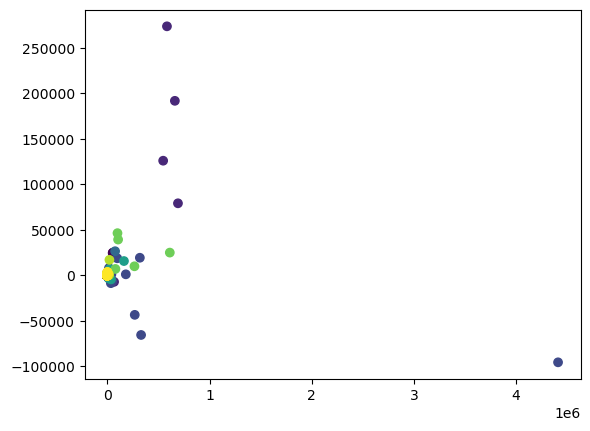

In [49]:
# Visualize training data
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(x_train_transformed)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_train)
# plt.legend(handles=plot.legend_elements()[0], labels=y_train)
plt.show()

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(x_train_transformed, y_train)

rfc.score(x_test_transformed, y_test)

0.5341409691629956

In [51]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, rfc.predict(x_test_transformed))
matrix.diagonal()/matrix.sum(axis=1)

array([0.32      , 0.52      , 0.81      , 0.10465116, 0.63953488,
       0.61      , 0.53488372, 0.62      , 0.39      , 0.64      ])

In [52]:
from sklearn.metrics import f1_score

f1_score(y_test, rfc.predict(x_test_transformed), average='macro')

0.5145431157529481

In [53]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [54]:
x_train_transformed_balanced, y_train_balanced = balanced_subsample(x_train_transformed, y_train)
x_test_transformed_balanced, y_test_balanced = balanced_subsample(x_test_transformed, y_test)

In [55]:
np.unique(y_test_balanced, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

In [56]:
np.unique(y_train_balanced, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([106, 106, 106, 106, 106, 106, 106, 106, 106, 106]))

In [57]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(x_train_transformed_balanced, y_train_balanced)

rfc.score(x_test_transformed_balanced, y_test_balanced)

0.502

In [58]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter = 10000, solver='adam', activation='relu', hidden_layer_sizes=(1000, 500,100,))
# print(one.fit_transform(y_train_balanced).toarray().shape)
mlp.fit(x_train_transformed, y_train)

mlp.score(x_test_transformed, y_test)

0.5374449339207048

In [186]:
mlp.out_activation_

'softmax'

In [59]:
from gtda.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42, n_estimators=1000)),
    ]
)
pipe.fit(persistence_diagrams, y_train)
pipe["rf"].oob_score_

0.5808068153345026

In [60]:
pipe.score(persistence.fit_transform(x_test), y_test)

0.5627753303964758

In [61]:

pipe = Pipeline(
    [
        ("features", feature_union),
        ("mlp", MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)),
    ]
)
pipe.fit(persistence_diagrams, y_train)
# pipe["rf"].oob_score_

Iteration 1, loss = 14.48055588
Iteration 2, loss = 6.46131757
Iteration 3, loss = 3.81329039
Iteration 4, loss = 3.09887753
Iteration 5, loss = 2.82525720
Iteration 6, loss = 2.58023185
Iteration 7, loss = 2.54067976
Iteration 8, loss = 2.41736637
Iteration 9, loss = 2.34611442
Iteration 10, loss = 2.22945866
Iteration 11, loss = 2.21307032
Iteration 12, loss = 2.15887700
Iteration 13, loss = 2.11168778
Iteration 14, loss = 2.11755553
Iteration 15, loss = 2.02179937
Iteration 16, loss = 1.97701296
Iteration 17, loss = 2.11258433
Iteration 18, loss = 2.15351971
Iteration 19, loss = 2.09316324
Iteration 20, loss = 1.98527778
Iteration 21, loss = 2.08294417
Iteration 22, loss = 1.94586764
Iteration 23, loss = 2.02009604
Iteration 24, loss = 1.95242096
Iteration 25, loss = 1.87721964
Iteration 26, loss = 1.80054513
Iteration 27, loss = 1.82834107
Iteration 28, loss = 1.81209837
Iteration 29, loss = 1.87606347
Iteration 30, loss = 1.84479511
Iteration 31, loss = 1.78495817
Iteration 32, lo

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                 PersistenceEntropy(normalize=True)),
                                                ('numberofpoints',
                                                 NumberOfPoints(n_jobs=-1)),
                                                ('amplitude-1',
                                                 Amplitude(metric='bottleneck',
                                                           n_jobs=-1)),
                                                ('amplitude-2',
                                                 Amplitude(metric='wasserstein',
                                                           n_jobs=-1)),
                                                ('amplitude-3',
                                                 Amplitude(n_jobs=-1)),
                                                ('amplitude-4',
                                     

In [62]:
from utils.kdtree import construct_kdtree_data


In [63]:
points, split_dims, inds, kdtree, split_positions = construct_kdtree_data(x_train[0], calc_split_positions=True)

In [64]:
x_train[0].shape

(128, 3)

In [65]:
from voxelize import Voxelizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [66]:
voxel_grids_train = []
for x_train_entry in x_train:
    voxel_grids_train.append(Voxelizer()(x_train_entry))

voxel_grids_test = []
for x_test_entry in x_test:
    voxel_grids_test.append(Voxelizer()(x_test_entry))

In [67]:
# voxels = []
indices_train = []
values_train = []
for voxel_grid_train in voxel_grids_train:
    voxels_train = voxel_grid_train.get_voxels()
    indices_train.append(np.transpose(np.stack(list(vx_train.grid_index for vx_train in voxels_train))))
    # indices_train[-1] = np.transpose(indices[-1])
    values_train.append(np.ones(indices_train[-1].shape[1], np.float32))

indices_test = []
values_test = []
for voxel_grid_test in voxel_grids_test:
    voxels_test = voxel_grid_test.get_voxels()
    indices_test.append(np.transpose(np.stack(list(vx_test.grid_index for vx_test in voxels_test))))
    # indices_train[-1] = np.transpose(indices[-1])
    values_test.append(np.ones(indices_test[-1].shape[1], np.float32))

In [68]:
indices_train[1].shape

(3, 124)

In [69]:
images_train = []
for indices_entry_train, values_entry_train in zip(indices_train, values_train):
    tensor = torch.sparse_coo_tensor(indices_entry_train, values_entry_train, size=(33,33,33))
    images_train.append(tensor.to_dense()[:32,:32,:32])

images_test = []
for indices_entry_test, values_entry_test in zip(indices_test, values_test):
    tensor = torch.sparse_coo_tensor(indices_entry_test, values_entry_test, size=(33,33,33))
    images_test.append(tensor.to_dense()[:32,:32,:32])

In [70]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


class Conv3DNet(nn.Module):
    def __init__(self):
        super(Conv3DNet, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)

        self.max_pooling = nn.MaxPool3d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(6912, 128)
        self.fc2 = nn.Linear(128, 10)
        return
    
    def forward(self, x):

        h = F.relu(self.conv1(x))
        # print(h.shape)
        h = F.relu(self.conv2(h))
        # print(h.shape)
        h = self.max_pooling(h)
        # print(h.shape)

        # h = h.reshape(-1, 6*6*6*32)
        h = torch.flatten(h, 1)
        # print(h.shape)

        h = F.relu(self.fc1(h))
        # print(h.shape)

        h = self.fc2(h)
        # print(h.shape)
        
        return h

In [269]:
net = Conv3DNet()

In [270]:
input = torch.randn(1, 1, 32, 32, 32)
out = net(input)
net.zero_grad()
out.backward(torch.randn(1, 10))

In [271]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [272]:
torch.stack(images_train).size()

torch.Size([3991, 32, 32, 32])

In [273]:
torch.from_numpy(y_train_one.toarray()).size()

torch.Size([3991, 10])

In [274]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, images_train, y_train_one):
        self.images_train = images_train
        self.labels = y_train_one

    def __len__(self):
        return len(self.images_train)
    
    def __getitem__(self, index):
        image = self.images_train[index]
        label = self.labels[index]
        return image, label

In [275]:
training_dataset = CustomDataset(images_train, y_train_one.toarray())
training_dataset.__len__()

3991

In [276]:
testing_dataset = CustomDataset(images_test, y_test_one.toarray())
testing_dataset.__len__()

908

In [277]:
from torch.utils.data import DataLoader
trainloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(testing_dataset, batch_size=32, shuffle=True)

In [278]:
for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    input, labels = data
    print(input.size())
    print(labels.size())
    if i == 0:
        break
    # zero the parameter gradients

torch.Size([32, 32, 32, 32])
torch.Size([32, 10])


In [279]:
loss_values = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # print(data.size())
        inputs, labels = data
        # print(labels.size())
        # print(inputs.size())
        bs = inputs.size()[0]
        inputs = inputs.reshape(bs,1,32,32,32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs.size())
        # print(labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * bs
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    loss_values.append(running_loss / len(training_dataset))

print('Finished Training')

Finished Training


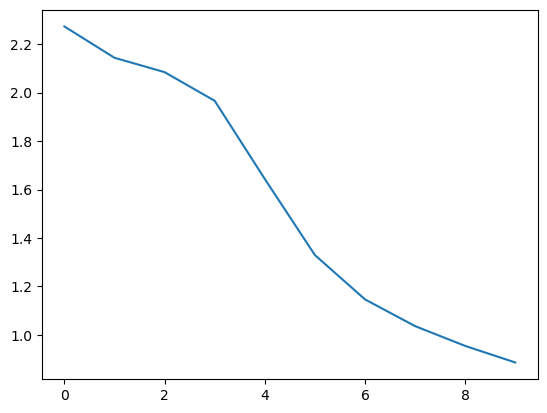

In [280]:
import matplotlib.pyplot as plt

plt.plot(loss_values)

In [281]:
test_loss = 0.0
correct, total = 0,0

for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    # print(data.size())
    inputs, labels = data
    # print(labels.size())
    # print(inputs.size())
    bs = inputs.size()[0]
    inputs = inputs.reshape(bs,1,32,32,32)
    # zero the parameter gradients

    # forward + backward + optimize
    outputs = net(inputs)

    for o,l in zip(outputs, labels):
        if torch.argmax(o)==torch.argmax(l):
            correct+=1
        total+=1

print(f'Correct Predictions: {correct}/{total}')
print('Test accuracy: ', correct/total)

Correct Predictions: 552/908
Test accuracy:  0.6079295154185022


In [321]:
class Conv3DNet_withPers(nn.Module):
    def __init__(self):
        super(Conv3DNet_withPers, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)

        self.max_pooling = nn.MaxPool3d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(6912, 128)
        self.fc2 = nn.Linear(128 + 128, 10)
        

        self.bn = nn.BatchNorm1d(256)
        self.fc_pers1 = nn.Linear(18, 1024)
        self.fc_pers2 = nn.Linear(1024, 512)
        self.fc_pers3 = nn.Linear(512, 128)
        # self.fc_pers4 = nn.Linear(128, 10)
        return
    
    def forward(self, x, x_features):

        h = F.relu(self.conv1(x))
        # print(h.shape)
        h = F.relu(self.conv2(h))
        # print(h.shape)
        h = self.max_pooling(h)
        # print(h.shape)

        # h = h.reshape(-1, 6*6*6*32)
        h = torch.flatten(h, 1)
        # print(h.shape)
        # print(x_features.shape)
        h_features = F.relu(self.fc_pers1(x_features))
        h_features = F.relu(self.fc_pers2(h_features))
        h_features = F.relu(self.fc_pers3(h_features))
        # h_features = F.softmax(self.fc_pers4(h_features))

        # print(h.shape)
        h = F.relu(self.fc1(h))
        # print(h.shape)
        h = torch.cat((h, h_features), dim=1)
        h = self.bn(h)        
        h = self.fc2(h)
        # print(h.shape)
        
        return h

In [322]:
net_withPers = Conv3DNet_withPers()

In [325]:
input = torch.randn(2, 1, 32, 32, 32)
dummy_features = torch.randn(2, 18)
out = net_withPers(input, dummy_features)
net_withPers.zero_grad()
out.backward(torch.randn(2, 10))

In [326]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_withPers.parameters(), lr=0.001, momentum=0.9)

In [327]:
from torch.utils.data import Dataset
class CustomDataset_withPers(Dataset):
    def __init__(self, images_train, x_features, y_train_one):
        self.images_train = images_train
        self.labels = y_train_one
        self.x_features = x_features

    def __len__(self):
        return len(self.images_train)
    
    def __getitem__(self, index):
        image = self.images_train[index]
        x_features = self.x_features[index]
        label = self.labels[index]
        return image, x_features, label

In [328]:
training_dataset = CustomDataset_withPers(images_train, x_train_transformed, y_train_one.toarray())
training_dataset.__len__()

3991

In [329]:
testing_dataset = CustomDataset_withPers(images_test, x_test_transformed, y_test_one.toarray())
testing_dataset.__len__()

908

In [330]:
x_test_transformed.shape

(908, 18)

In [331]:
trainloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(testing_dataset, batch_size=32, shuffle=True)

In [332]:
loss_values = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, x_features, labels = data
        # print(x_features.dtype)
        # print(inputs.dtype)
        # inputs = tf.cast(inputs, tf.float(64))
        # inputs = inputs.type('torch.DoubleTensor')
        # print(inputs.dtype)
        x_features = x_features.type('torch.FloatTensor')
        bs = inputs.size()[0]
        inputs = inputs.reshape(bs,1,32,32,32)
        # x_features = x_features.reshape(bs, 18)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_withPers(inputs, x_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * bs
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    loss_values.append(running_loss / len(training_dataset))

print('Finished Training')

Finished Training


In [333]:
test_loss = 0.0
correct, total = 0,0

for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    # print(data.size())
    inputs, x_features, labels = data
    x_features = x_features.type('torch.FloatTensor')

    # print(labels.size())
    # print(inputs.size())
    bs = inputs.size()[0]
    inputs = inputs.reshape(bs,1,32,32,32)
    # zero the parameter gradients

    # forward + backward + optimize
    outputs = net_withPers(inputs, x_features)

    for o,l in zip(outputs, labels):
        if torch.argmax(o)==torch.argmax(l):
            correct+=1
        total+=1

print(f'Correct Predictions: {correct}/{total}')
print('Test accuracy: ', correct/total)

Correct Predictions: 710/908
Test accuracy:  0.7819383259911894


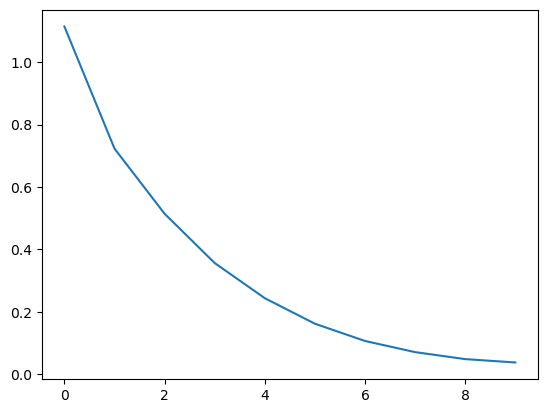

In [334]:
plt.plot(loss_values)